### Customize pyCTW tutorial example to my ssh timeseries

In [103]:
# We begin by importing the relevant libraries. Please make sure that PyCWT is
# properly installed in your system.
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pycwt as wavelet
from pycwt.helpers import find

# My additional imports
import cmocean as cmo
import datetime as dt
from matplotlib.dates import date2num
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import os
import ssh_tools as ssht # my module
import tide_tools as tidet # my module
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

In [112]:
station = 'LaJolla/'
st_id = '9410230'
#filename = '../NOAA-seaLevel/' + station + '/CO-OPS_'+st_id + '_jan_aug.csv' # looong file w/ jan-aug data
filename = '../NOAA-seaLevel/' + station  + '/CO-OPS_'+ st_id + '_met_' + 'jan.csv'
col_names = ["Date","Time","Predicted","Preliminary","Verified"]

title = 'Sea level residual'
label = 'SSH'
units = 'm'
#t0 = 1871.0
dt = 0.1  # in hours

# de-tide timeseries
omegas = tidet.define_constituents()
data = pd.read_csv(filename, parse_dates=[['Date', 'Time']], names=col_names) 
data['datetime'] = pd.to_datetime(data['Date_Time'][1:], format='%Y/%m/%d %H:%M')
data_new = data.set_index('datetime')
ssh = pd.to_numeric(data_new['Verified'], errors='coerce')
 
# Time vector of seconds (generate timedelta vector and convert to seconds)
T = (data['datetime'][1:]-data['datetime'][1])/ np.timedelta64(1, 's')
T[1] = 1
A, level = tidet.fit_harmonics(omegas, T, ssh[1:])

Text(0.5, 1.0, 'Sea level residual (no tides)')

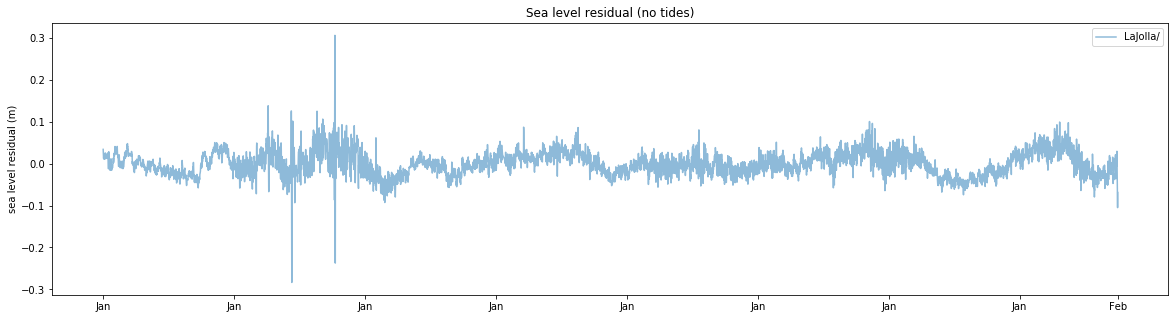

In [113]:
fig, ax = plt.subplots(1,1, figsize=(20,5), sharey=True)
ax.plot(ssh.index[1:],ssh.values[1:]-np.squeeze(level), alpha=0.5, label=station)

ax.set_ylabel('sea level residual (m)') 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Sea level residual (no tides)')

In [143]:
# Tut: We also create a time array in hours.
t = (1/3600)*T.copy() 

# Tut: We write the following code to detrend and normalize the input data by its
# standard deviation. Sometimes detrending is not necessary and simply
# removing the mean value is good enough. However, if your dataset has a well
# defined trend, such as the Mauna Loa CO\ :sub:`2` dataset available in the
# above mentioned website, it is strongly advised to perform detrending.
# KRM: I'll just subtract the mean...
dat = ssh.values[1:]-np.squeeze(level)
dat_notrend = dat - np.nanmean(dat)
std = np.std(dat_notrend)
var = std**2
dat_norm = dat_notrend / std # Normalized dataset
N = len(dat_norm.values)

In [144]:
# Tut: The next step is to define some parameters of our wavelet analysis. We
# select the mother wavelet, in this case the Morlet wavelet with
# :math:`\omega_0=6`.
mother = wavelet.Morlet(6) 
s0 = 2 * dt  # Starting scale, in this case 2 * 0.1 hr = 12 min
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 16 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

In [145]:
# The following routines perform the wavelet transform and inverse wavelet
# transform using the parameters defined above. Since we have normalized our
# input time-series, we multiply the inverse transform by the standard
# deviation.
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm.values, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

In [146]:
# We calculate the normalized wavelet and Fourier power spectra, as well as
# the Fourier equivalent periods for each wavelet scale.
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

In [147]:
# We could stop at this point and plot our results. However we are also
# interested in the power spectra significance test. The power is significant
# where the ratio ``power / sig95 > 1``.
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

# Then, we calculate the global wavelet spectrum and determine its
# significance level.
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

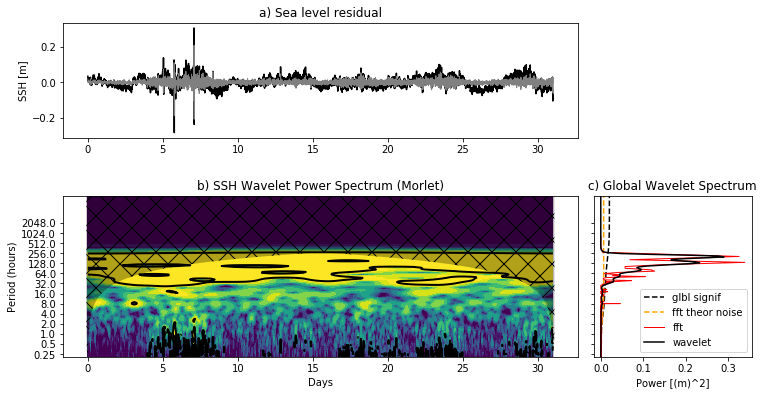

In [148]:
# Tut: Finally, we plot our results in four different subplots containing the
# (i) original series anomaly and the inverse wavelet transform; (ii) the
# wavelet power spectrum (iii) the global wavelet and Fourier spectra ; and
# (iv) the range averaged wavelet spectrum. In all sub-plots the significance
# levels are either included as dotted lines or as filled contour lines.
# KRM: I didn't do the avg scales

# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t/(24), dat, 'k', linewidth=1.5)
ax.plot(t/(24), iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t/(24), numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [(t/(24)).min(), (t/(24)).max(), 0, max(period)]
bx.contour(t/(24), numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t/(24), t[-1:]/(24) + dt, t[-1:]/(24) + dt,
                           t[:1]/(24) - dt, t[:1]/(24) - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (hours)')
bx.set_xlabel('Days')
#
#Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
#                           numpy.ceil(numpy.log2(period.max())))
#bx.set_yticks(numpy.log2(Yticks))
#bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--', label='glbl signif')
cx.plot(var * fft_theor, numpy.log2(period), '--', color='orange',label='fft theor noise')
cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='red', label='fft',
        linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5, label = 'wavelet')
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
#cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
cx.legend()
pyplot.setp(cx.get_yticklabels(), visible=False)

pyplot.show()

In [135]:
t[7000]

251964.0

In [140]:
251964/(24*60)

174.975

In [139]:
24*31

744

In [142]:
T*(1/3600)

1         0.000278
2         0.100000
3         0.200000
4         0.300000
5         0.400000
           ...    
7436    743.500000
7437    743.600000
7438    743.700000
7439    743.800000
7440    743.900000
Name: datetime, Length: 7440, dtype: float64